## Techniques for determining cell boundaries

In [1]:
from datetime import datetime
print(datetime.today())

2021-03-10 21:21:41.262408


In [2]:
!tesseract -v

tesseract 4.1.1
 leptonica-1.80.0
  libgif 5.2.1 : libjpeg 9d : libpng 1.6.37 : libtiff 4.1.0 : zlib 1.2.11 : libwebp 1.1.0 : libopenjp2 2.3.1
 Found AVX2
 Found AVX
 Found FMA
 Found SSE


In [3]:
!pip install --upgrade pip
!pip install --user --upgrade "opencv-python"
!pip install --upgrade wget
!pip install --upgrade pytesseract

In [4]:
import os
import wget
import cv2 
import numpy as np
import time
import uuid
import matplotlib.pyplot as plt
import pytesseract
import logging

dir_path = 'test'
purple = (200, 0, 200)
plt.rcParams['figure.dpi'] = 150

In [5]:
%pwd

'/Users/jk/DevelopmentEnvironment/Voice_Gateway_SOE/Notebooks'

In [6]:
%cd ..
import image_utils
%pwd
plt.rcParams['figure.dpi'] = 150

/Users/jk/DevelopmentEnvironment/Voice_Gateway_SOE


In [7]:
def get_cell_boundaries(image):

    # Find all the lines in the matrix_image
    horizontal_lines, vertical_lines = image_utils.find_lines(image)

    def horizontal_sort_func(i):
        return (min(i[0][1], i[0][3]))

    def vertical_sort_func(i):
        return (min(i[0][0], i[0][2]))

    # Now look for the internal coordinates of the matrix cells. Do this first for the horizontal lines,
    # which will give us the y axis coordinates of the cells.
    # 1. Sort by the y value of the line (since the line may not be exactly vertical, sort by the min
    #    y value of the two end points.
    # 2. Since lines are 1 pixel wide, starting at the top, go pixel by pixel. If we have a line that is
    #    the same y value as the previous or is +1, we know we're in the same line in the matrix matrix_image
    #    (which are > 1 pixel wide.
    # 3. Otherwise if there is more of a gap (looking for at least 2 pixels),
    #    we know we've traversed a cell and are hitting the start
    #    of the line at the other side.
    # 4. In this case, add the coordinates to the list of coordinates.
    horizontal_lines.sort(key=horizontal_sort_func)
    y_coords = []
    y_coord_deltas = []
    for i in range(0, len(horizontal_lines) - 1):
        if horizontal_lines[i + 1][0][1] > horizontal_lines[i][0][1] + 2:
            y_coords.append([horizontal_lines[i][0][1] + 1, horizontal_lines[i + 1][0][1] - 1])
            y_coord_deltas.append((horizontal_lines[i + 1][0][1] - 1) - (horizontal_lines[i][0][1] + 1))

    # Now same for vertical lines and values on the x axis
    vertical_lines.sort(key=vertical_sort_func)
    x_coords = []
    x_coord_deltas = []
    for i in range(0, len(vertical_lines) - 1):
        if vertical_lines[i + 1][0][0] > vertical_lines[i][0][0] + 2:
            x_coords.append([vertical_lines[i][0][0] + 1, vertical_lines[i + 1][0][0] - 1])
            x_coord_deltas.append((vertical_lines[i + 1][0][0] - 1) - (vertical_lines[i][0][0] + 1))

    # This routine is used if we find too many lines resulting in too many cells
    def reduce_coords(coords, coord_deltas):

        # First find the likely size of the width of the row column through a histogram of the
        # widths. There can be noise on the outside edges of the puzzle matrix_image which will result in
        # a larger number of rows/cols of very small width. There can also be noise within a row/column
        # if there are a large number of digits. The amount of ink from these digits can cause a line to be
        # detected.
        #
        # Given this, the approach is to first look for the histogram element with the most entries. If this is
        # the first element, meaning the rows/cols with the smallest width, assume this is noise, eliminate it
        # and repeat. Repeat until this is not the case. Then take the element with the most entries.
        # If the entries on either side are also non-zero use them too. Calculate the allowable width as the
        # span across these entries.

        # Histogram size is important. Tried 20 and there was too much variability in pics and
        # widths that caused valid rows/columns to be excluded. Trying 10 now.
        histogram_size = 10
        widths_histogram = np.histogram(coord_deltas, bins=histogram_size)
        logging.info("Initial coords:\t%s" % coords)
        logging.info('Coord deltas:\t%s' % coord_deltas)
        logging.info(widths_histogram)

        done = False
        histogram_frequency = widths_histogram[0]
        histogram_bounds = widths_histogram[1]
        while not done:
            max_index = np.argmax(histogram_frequency)
            if max_index == 0:
                histogram_frequency = np.delete(histogram_frequency, 0)
                histogram_bounds = np.delete(histogram_bounds, 0)
            else:
                min_width = histogram_bounds[max_index]
                max_width = histogram_bounds[max_index + 1]
                if histogram_frequency[max_index - 1] > 0:
                    min_width = histogram_bounds[max_index - 1]
                if max_index <= len(histogram_frequency) - 2:
                    if histogram_frequency[max_index + 1] > 0:
                        max_width = histogram_bounds[max_index + 2]
                done = True

        # We're going to add some wiggle room to the max and min for when we split and combine rows/cols later to
        # prevent the calculations from resulting in something slightly out of the range
        min_width = min_width * .9
        max_width = max_width * 1.1
        
        print('min width: %s' % min_width)
        print('max width: %s' % max_width)
        
        # start by collecting the entries of the desired size and computing the average line width
        line_width_total = 0
        line_width_count = 0 
        previous_valid_entry = -2
        new_coords = []
        for i in range(len(coords)):
            if min_width <= coords[i][1] - coords[i][0] <= max_width:
                new_coords.append(coords[i])
                if i == previous_valid_entry + 1:
                    line_width_total += (coords[i][0] - coords[i-1][1])
                    line_width_count += 1
                previous_valid_entry = i
        
        if line_width_count > 0:
            average_line_width = int(line_width_total / line_width_count)
        else:
            average_line_width = 0
            
        # It's possible that we may have reduced too far. This'll likely be interior cells missing because
        # the matrix line was either too faint and was missed or we identified an extra line splitting 
        # a row or column causing the cells to be too narrow. What we're looking for is a gap between the
        # cell coordinates identified so far that is a multiple of the identified cell width (height). 
        # We're only looking for gaps up to a multiple of 3 valid widths because anything larger points
        # to bigger issues.
        print('Before: %s' % new_coords)
        if len(new_coords) < 9:
            for i in range(1,len(new_coords)):
                gap = new_coords[i][0] - new_coords[i-1][1]
                if min_width <= gap - 2 * average_line_width <=  max_width:
                    # found a gap of width of one cell
                    new_entry = [new_coords[i-1][1] + average_line_width,
                                new_coords[i][0] - average_line_width]
                    new_coords.insert(i, new_entry)
                elif min_width <= (gap - 3 * average_line_width) / 2  <= max_width: 
                    # found a gap of width of two cells
                    cell_width = int((gap - average_line_width * 3) / 2)
                    new_entry_1 = [new_coords[i-1][1] + average_line_width,
                                new_coords[i-1][1] + average_line_width + cell_width]
                    new_entry_2 = [new_coords[i][0] - average_line_width - cell_width,
                                new_coords[i][0] - average_line_width]
                    new_coords.insert(i, new_entry_2)
                    new_coords.insert(i, new_entry_1)
                elif min_width <= (gap - 4 * average_line_width) / 3   <= max_width:
                    # found a gap of width of three cells
                    cell_width = int((gap - average_line_width * 4) / 3)
                    new_entry_1 = [new_coords[i-1][1] + average_line_width,
                                new_coords[i-1][1] + average_line_width + cell_width]
                    new_entry_2 = [new_coords[i-1][1] + average_line_width * 2 + cell_width,
                                new_coords[i-1][1] + average_line_width * 2 + cell_width * 2]
                    new_entry_3 = [new_coords[i][0] - average_line_width - cell_width,
                                new_coords[i][0] - average_line_width]
                    new_coords.insert(i, new_entry_3)
                    new_coords.insert(i, new_entry_2)
                    new_coords.insert(i, new_entry_1)
                if len(coords) == 9:
                    break
        print('After: %s' % new_coords)
        return new_coords
    
    coords_image = image_utils.generate_image_with_input(image, x_coords, y_coords)
    image_utils.show_image(coords_image, title='Before Reduction')

    if len(y_coords) > 9:
        print('Y coords')
        y_coords = reduce_coords(y_coords, y_coord_deltas)
    if len(x_coords) > 9:
        print('X coords')
        x_coords = reduce_coords(x_coords, x_coord_deltas)
    
    coords_image = image_utils.generate_image_with_input(image, x_coords, y_coords)
    image_utils.show_image(coords_image, title='After Reduction')

    return x_coords, y_coords, [vertical_lines, horizontal_lines]



Image: IMG_1428-high.jpg
Shape: [4032, 3024]

Threshold: 1512
Horizontal lines: 301
Vertical lines: 150
Rejected lines: 10


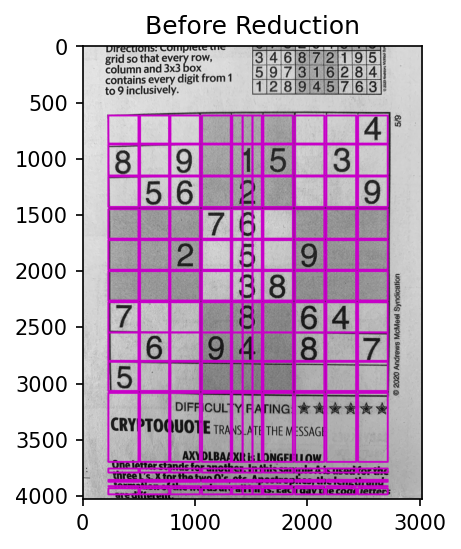

Y coords
min width: 221.57999999999998
max width: 338.25
Before: [[618, 868], [876, 1152], [1161, 1432], [1452, 1714], [1727, 1991], [2003, 2265], [2280, 2548], [2550, 2802], [2810, 3070]]
After: [[618, 868], [876, 1152], [1161, 1432], [1452, 1714], [1727, 1991], [2003, 2265], [2280, 2548], [2550, 2802], [2810, 3070]]
X coords
min width: 224.46
max width: 294.8
Before: [[225, 493], [507, 765], [777, 1039], [1058, 1314], [1604, 1866], [1886, 2146], [2164, 2429], [2446, 2710]]
After: [[225, 493], [507, 765], [777, 1039], [1058, 1314], [1330, 1588], [1604, 1866], [1886, 2146], [2164, 2429], [2446, 2710]]


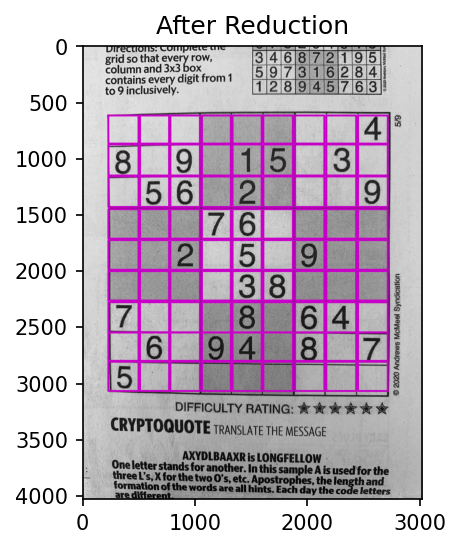

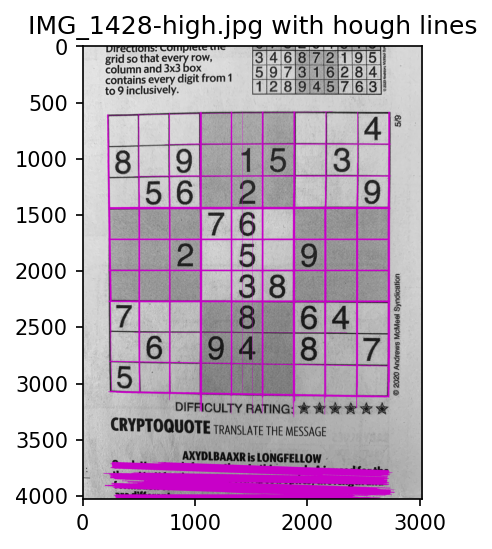

y_coords: [[618, 868], [876, 1152], [1161, 1432], [1452, 1714], [1727, 1991], [2003, 2265], [2280, 2548], [2550, 2802], [2810, 3070]]
x_coords: [[225, 493], [507, 765], [777, 1039], [1058, 1314], [1330, 1588], [1604, 1866], [1886, 2146], [2164, 2429], [2446, 2710]]


Image: IMG_1631-low.jpg
Shape: [3024, 3024]

Threshold: 1512
Horizontal lines: 162
Vertical lines: 128
Rejected lines: 52


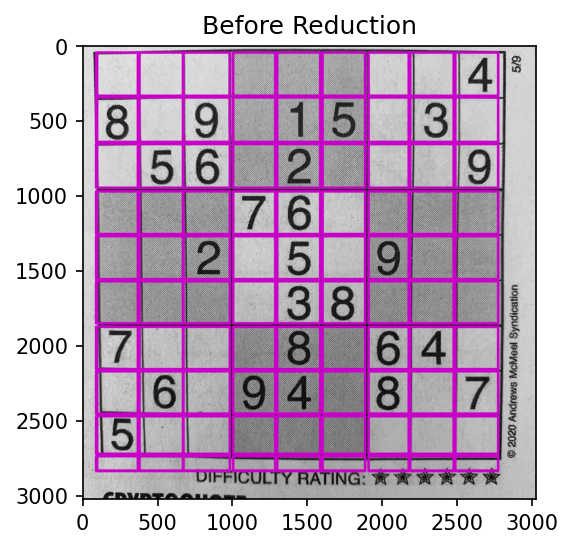

Y coords
min width: 214.02
max width: 326.70000000000005
Before: [[43, 332], [343, 640], [654, 946], [970, 1255], [1269, 1556], [1570, 1851], [1874, 2157], [2171, 2454], [2471, 2722]]
After: [[43, 332], [343, 640], [654, 946], [970, 1255], [1269, 1556], [1570, 1851], [1874, 2157], [2171, 2454], [2471, 2722]]
X coords
min width: 223.38
max width: 341.0
Before: [[94, 366], [377, 667], [670, 980], [1002, 1283], [1296, 1583], [1599, 1883], [1906, 2174], [2184, 2474], [2485, 2771]]
After: [[94, 366], [377, 667], [670, 980], [1002, 1283], [1296, 1583], [1599, 1883], [1906, 2174], [2184, 2474], [2485, 2771]]


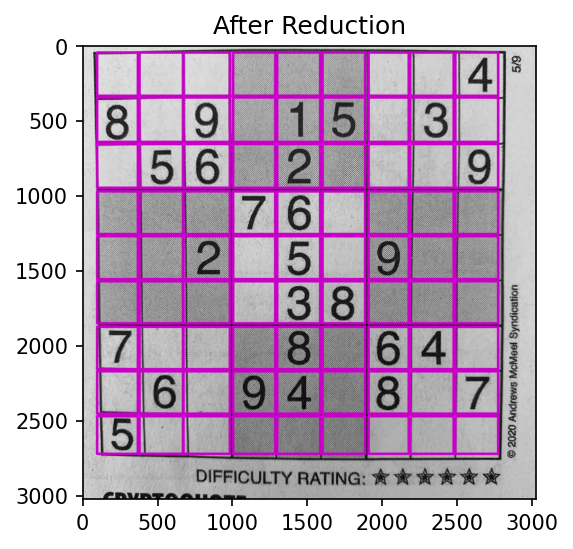

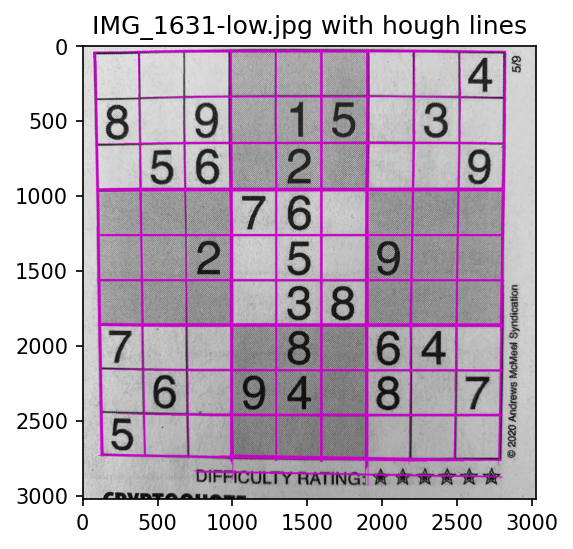

y_coords: [[43, 332], [343, 640], [654, 946], [970, 1255], [1269, 1556], [1570, 1851], [1874, 2157], [2171, 2454], [2471, 2722]]
x_coords: [[94, 366], [377, 667], [670, 980], [1002, 1283], [1296, 1583], [1599, 1883], [1906, 2174], [2184, 2474], [2485, 2771]]


Image: IMG_1784.jpg
Shape: [4032, 3024]

Threshold: 1512
Horizontal lines: 80
Vertical lines: 1312
Rejected lines: 551

Threshold: 1512
Horizontal lines: 350
Vertical lines: 249
Rejected lines: 6


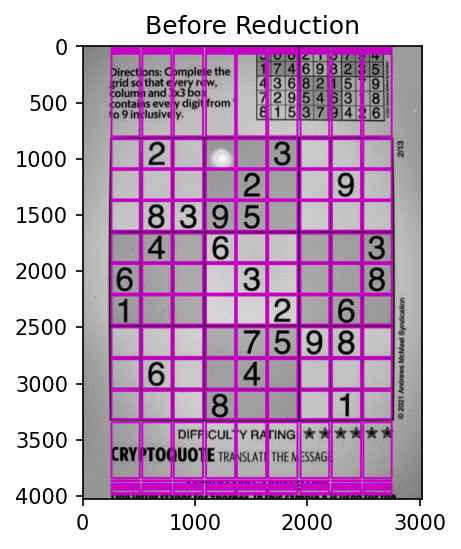

Y coords
min width: 199.35
max width: 324.5
Before: [[829, 1087], [1102, 1365], [1380, 1643], [1669, 1923], [1941, 2203], [2220, 2478], [2504, 2767], [2787, 3047], [3069, 3320]]
After: [[829, 1087], [1102, 1365], [1380, 1643], [1669, 1923], [1941, 2203], [2220, 2478], [2504, 2767], [2787, 3047], [3069, 3320]]


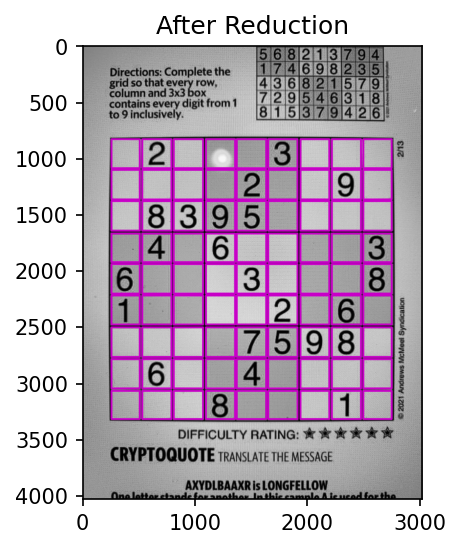

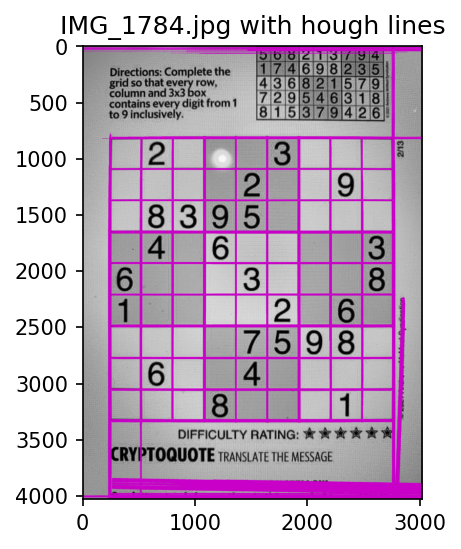

y_coords: [[829, 1087], [1102, 1365], [1380, 1643], [1669, 1923], [1941, 2203], [2220, 2478], [2504, 2767], [2787, 3047], [3069, 3320]]
x_coords: [[253, 504], [527, 786], [807, 1067], [1093, 1352], [1367, 1629], [1647, 1907], [1934, 2190], [2213, 2472], [2493, 2745]]


Image: IMG_1428-low.jpg
Shape: [4032, 3024]

Threshold: 1512
Horizontal lines: 284
Vertical lines: 159
Rejected lines: 23


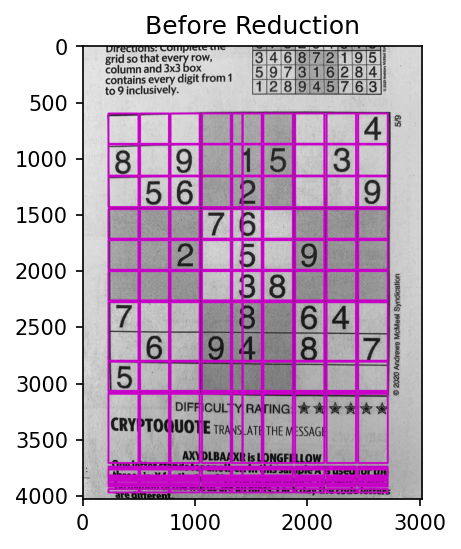

Y coords
min width: 222.3
max width: 339.35
Before: [[600, 870], [876, 1153], [1160, 1433], [1452, 1714], [1727, 1991], [2003, 2264], [2809, 3069]]
After: [[600, 870], [876, 1153], [1160, 1433], [1452, 1714], [1727, 1991], [2003, 2264], [2275, 2531], [2542, 2798], [2809, 3069]]
X coords
min width: 224.36999999999998
max width: 293.70000000000005
Before: [[226, 493], [507, 764], [778, 1037], [1058, 1314], [1604, 1866], [1886, 2146], [2166, 2428], [2447, 2710]]
After: [[226, 493], [507, 764], [778, 1037], [1058, 1314], [1332, 1586], [1604, 1866], [1886, 2146], [2166, 2428], [2447, 2710]]


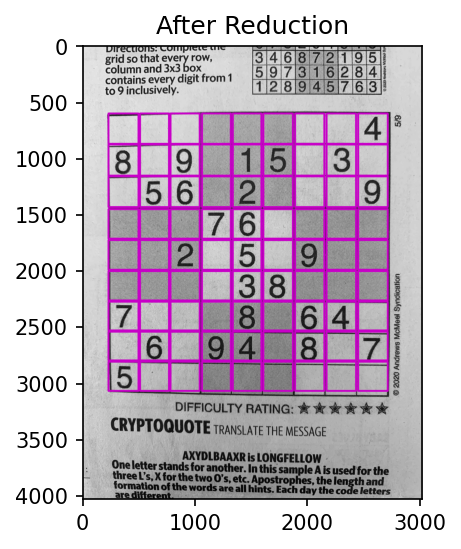

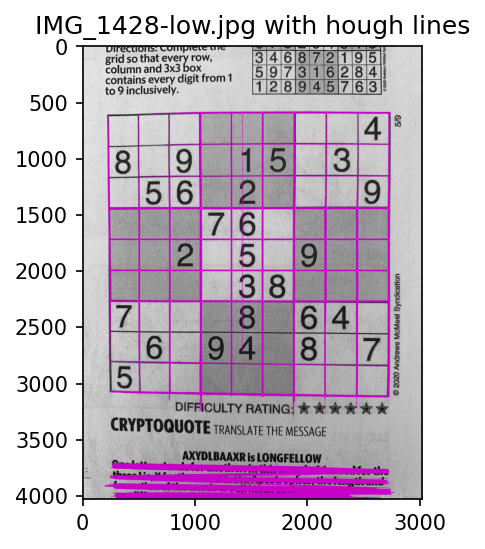

y_coords: [[600, 870], [876, 1153], [1160, 1433], [1452, 1714], [1727, 1991], [2003, 2264], [2275, 2531], [2542, 2798], [2809, 3069]]
x_coords: [[226, 493], [507, 764], [778, 1037], [1058, 1314], [1332, 1586], [1604, 1866], [1886, 2146], [2166, 2428], [2447, 2710]]


Image: IMG_1758.jpg
Shape: [4032, 3024]

Threshold: 1512
Horizontal lines: 636
Vertical lines: 356
Rejected lines: 220


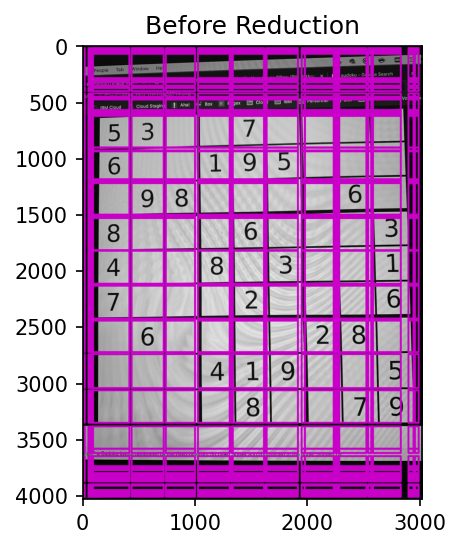

Y coords
min width: 224.1
max width: 342.1
Before: [[605, 905], [929, 1185], [1220, 1500], [1531, 1816], [1822, 2127], [2124, 2435], [2430, 2724], [2742, 3044], [3064, 3353]]
After: [[605, 905], [929, 1185], [1220, 1500], [1531, 1816], [1822, 2127], [2124, 2435], [2430, 2724], [2742, 3044], [3064, 3353]]
X coords
min width: 203.76000000000005
max width: 355.3
Before: [[89, 412], [432, 717], [736, 996], [1022, 1304], [1332, 1609], [1633, 1911], [1974, 2229], [2279, 2520], [2579, 2826]]
After: [[89, 412], [432, 717], [736, 996], [1022, 1304], [1332, 1609], [1633, 1911], [1974, 2229], [2279, 2520], [2579, 2826]]


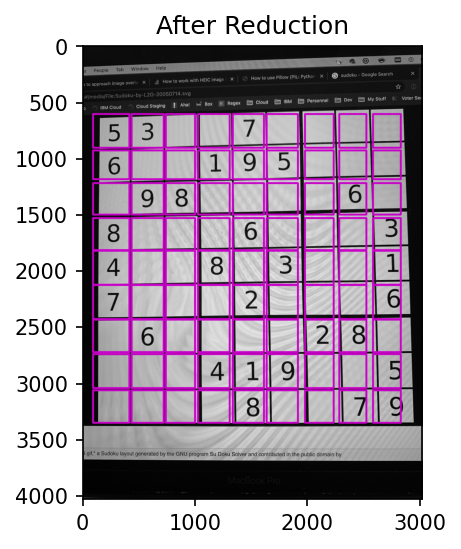

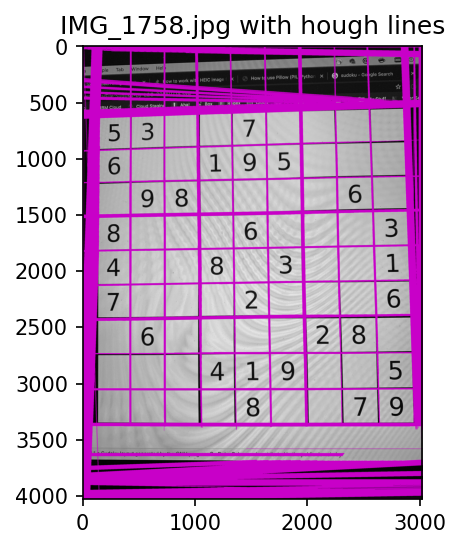

y_coords: [[605, 905], [929, 1185], [1220, 1500], [1531, 1816], [1822, 2127], [2124, 2435], [2430, 2724], [2742, 3044], [3064, 3353]]
x_coords: [[89, 412], [432, 717], [736, 996], [1022, 1304], [1332, 1609], [1633, 1911], [1974, 2229], [2279, 2520], [2579, 2826]]


Image: sudokupuzzler.26.jpg
Shape: [2534, 2527]

Threshold: 1263
Horizontal lines: 93
Vertical lines: 94
Rejected lines: 0


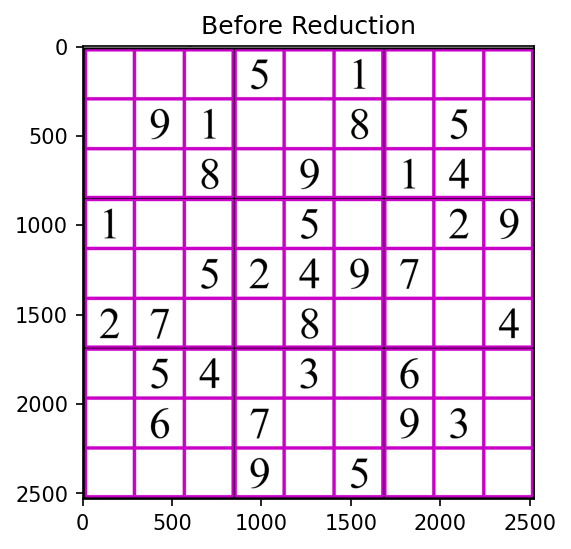

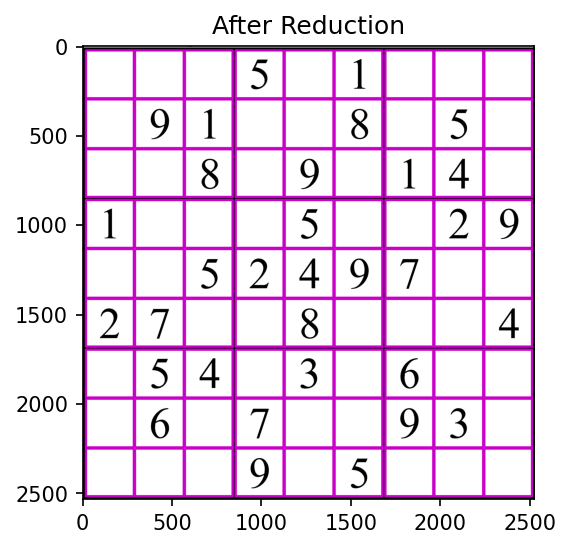

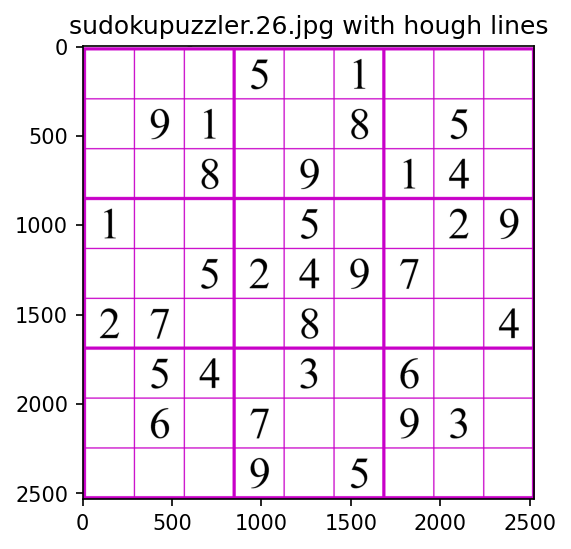

y_coords: [[24, 292], [298, 571], [577, 844], [861, 1129], [1135, 1408], [1414, 1681], [1698, 1966], [1972, 2245], [2251, 2518]]
x_coords: [[16, 284], [290, 563], [569, 836], [853, 1121], [1127, 1400], [1406, 1673], [1690, 1958], [1964, 2237], [2243, 2510]]


Image: IMG_1758.png
Shape: [4032, 3024]

Threshold: 1512
Horizontal lines: 536
Vertical lines: 390
Rejected lines: 274


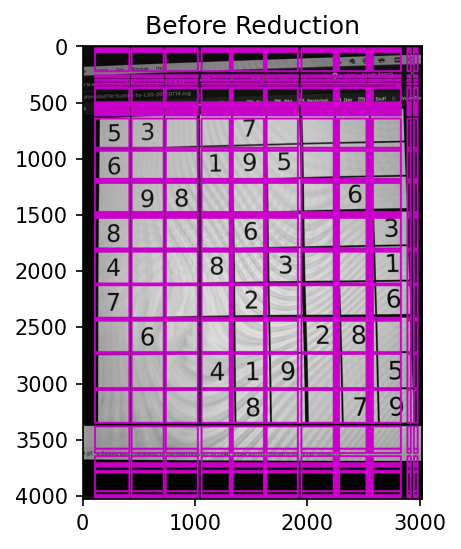

Y coords
min width: 224.82000000000002
max width: 343.20000000000005
Before: [[645, 905], [926, 1182], [1218, 1477], [1529, 1815], [1830, 2125], [2120, 2432], [2443, 2724], [2740, 3044], [3062, 3353]]
After: [[645, 905], [926, 1182], [1218, 1477], [1529, 1815], [1830, 2125], [2120, 2432], [2443, 2724], [2740, 3044], [3062, 3353]]
X coords
min width: 220.5
max width: 336.6
Before: [[106, 412], [432, 717], [736, 1021], [1054, 1304], [1332, 1609], [1633, 1911], [1942, 2229], [2277, 2521], [2578, 2827]]
After: [[106, 412], [432, 717], [736, 1021], [1054, 1304], [1332, 1609], [1633, 1911], [1942, 2229], [2277, 2521], [2578, 2827]]


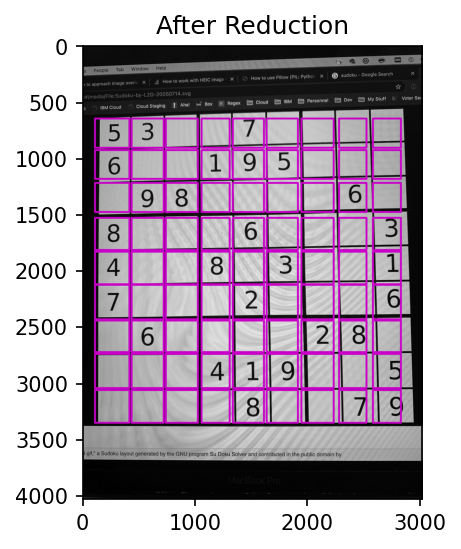

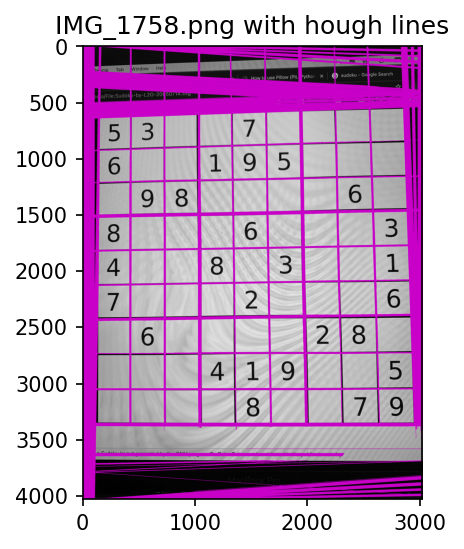

y_coords: [[645, 905], [926, 1182], [1218, 1477], [1529, 1815], [1830, 2125], [2120, 2432], [2443, 2724], [2740, 3044], [3062, 3353]]
x_coords: [[106, 412], [432, 717], [736, 1021], [1054, 1304], [1332, 1609], [1633, 1911], [1942, 2229], [2277, 2521], [2578, 2827]]


Image: Sudoku_20200509.png
Shape: [1138, 1044]

Threshold: 522
Horizontal lines: 44
Vertical lines: 42
Rejected lines: 0


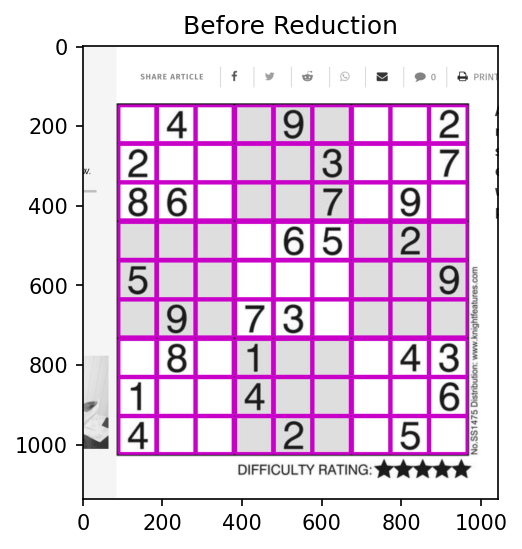

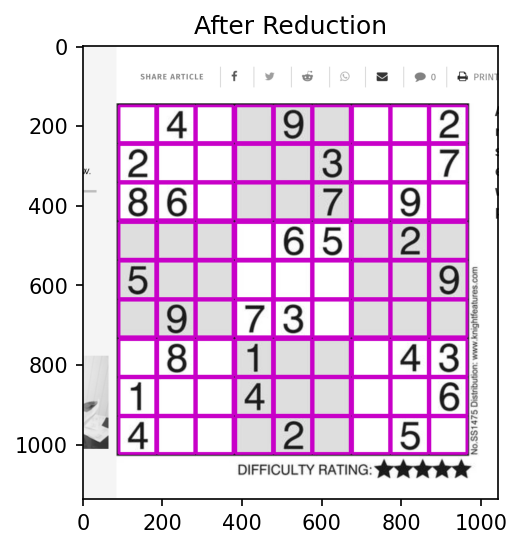

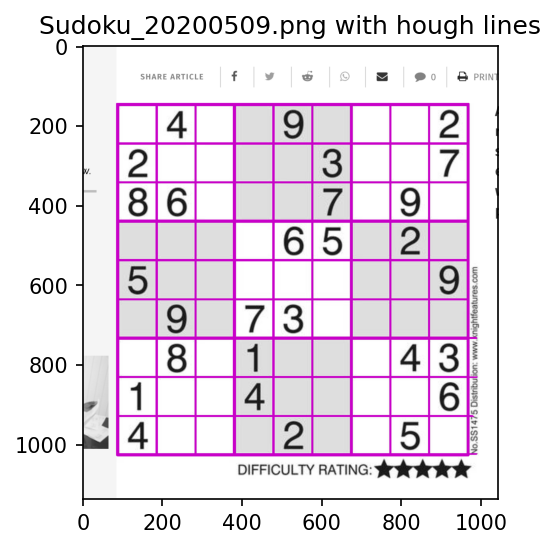

y_coords: [[150, 242], [247, 340], [344, 436], [443, 535], [540, 634], [638, 730], [737, 829], [833, 927], [931, 1023]]
x_coords: [[90, 182], [187, 280], [284, 376], [383, 475], [480, 573], [577, 670], [676, 769], [773, 866], [870, 963]]


Image: Sudoku-2020-10-29.png
Shape: [713, 750]

Threshold: 356
Horizontal lines: 26
Vertical lines: 26
Rejected lines: 0


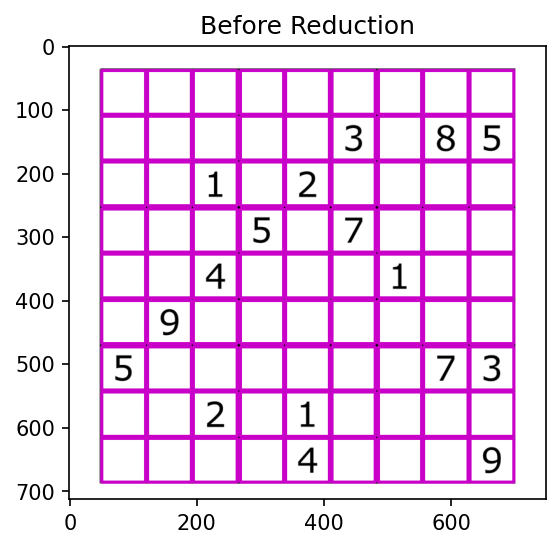

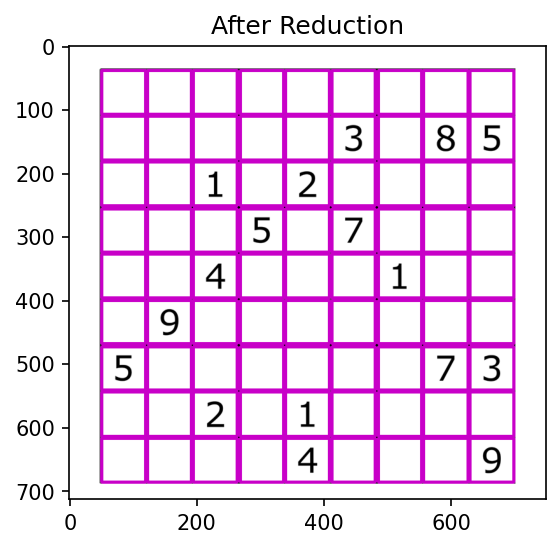

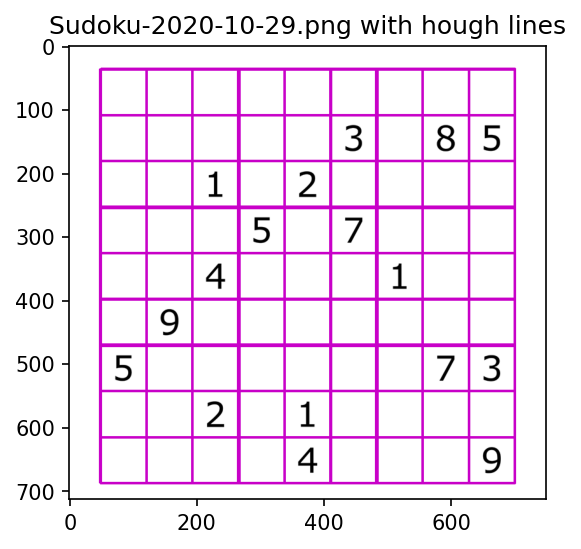

y_coords: [[38, 107], [110, 179], [182, 251], [256, 324], [327, 396], [400, 468], [473, 541], [544, 614], [617, 686]]
x_coords: [[51, 120], [123, 192], [195, 264], [269, 337], [340, 409], [413, 481], [486, 554], [557, 627], [630, 699]]


Image: sudoku2.png
Shape: [956, 1024]

Threshold: 478
Horizontal lines: 73
Vertical lines: 72
Rejected lines: 0


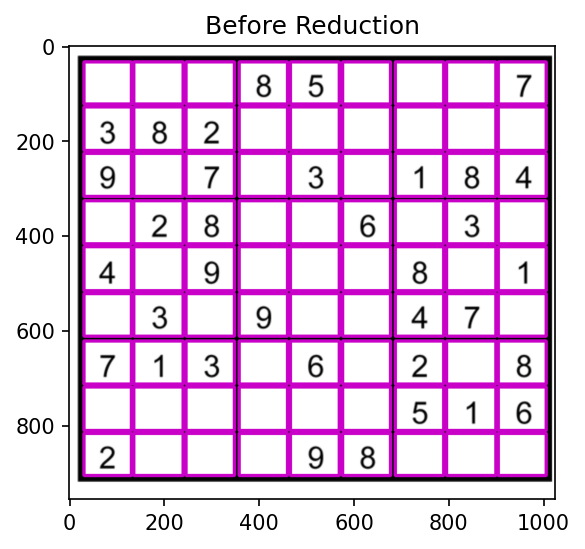

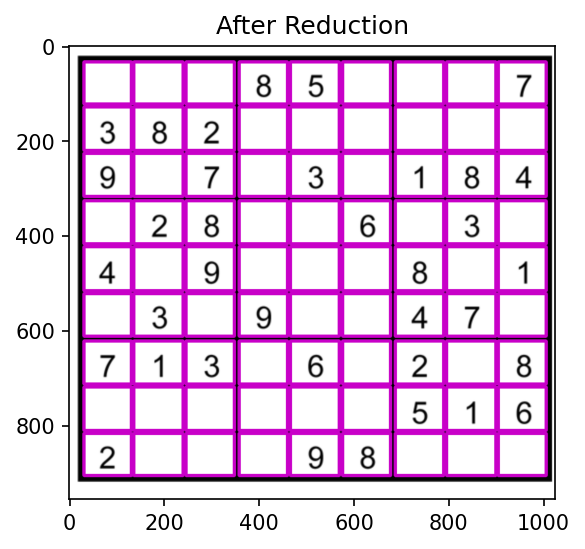

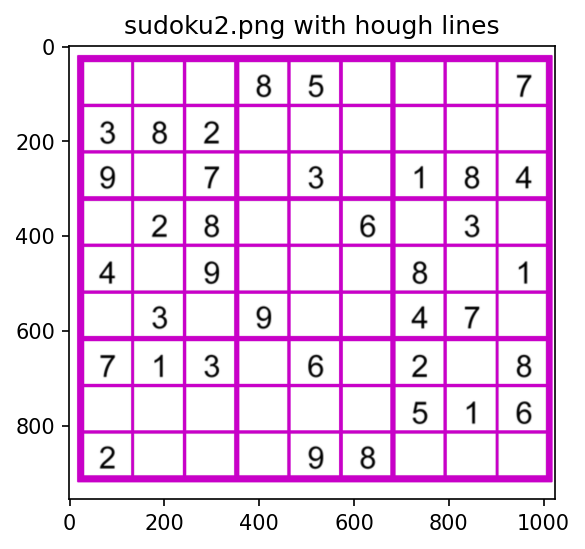

y_coords: [[33, 122], [128, 220], [226, 317], [326, 417], [423, 516], [522, 612], [622, 713], [719, 811], [817, 906]]
x_coords: [[31, 131], [136, 240], [246, 348], [358, 460], [466, 569], [576, 677], [687, 789], [795, 899], [904, 1005]]


Image: IMG_1773.jpg
Shape: [4032, 3024]

Threshold: 1512
Horizontal lines: 240
Vertical lines: 159
Rejected lines: 350


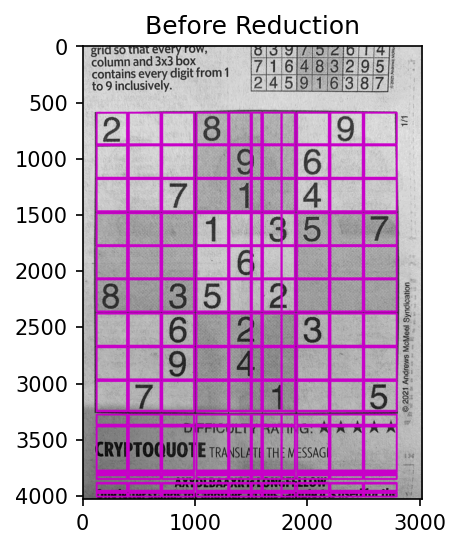

Y coords
min width: 212.04000000000002
max width: 345.18000000000006
Before: [[593, 874], [884, 1172], [1184, 1470], [1488, 1772], [1781, 2067], [2077, 2362], [2381, 2667], [2681, 2967], [2981, 3246]]
After: [[593, 874], [884, 1172], [1184, 1470], [1488, 1772], [1781, 2067], [2077, 2362], [2381, 2667], [2681, 2967], [2981, 3246]]
X coords
min width: 234.27
max width: 317.90000000000003
Before: [[121, 391], [407, 689], [704, 987], [1009, 1290], [1904, 2186], [2200, 2488], [2501, 2790]]
After: [[121, 391], [407, 689], [704, 987], [1009, 1290], [1306, 1589], [1605, 1888], [1904, 2186], [2200, 2488], [2501, 2790]]


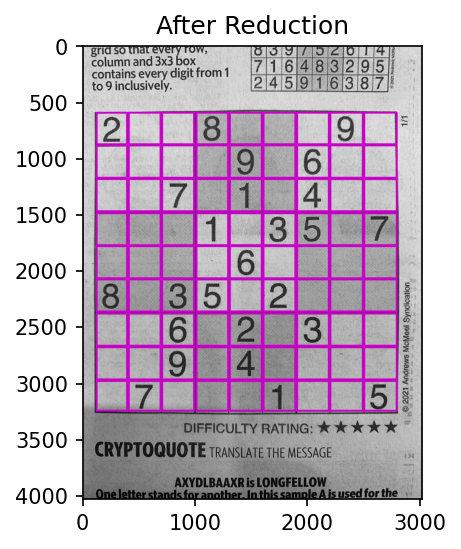

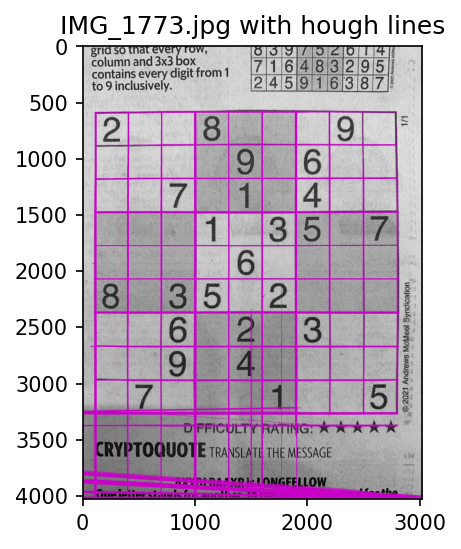

y_coords: [[593, 874], [884, 1172], [1184, 1470], [1488, 1772], [1781, 2067], [2077, 2362], [2381, 2667], [2681, 2967], [2981, 3246]]
x_coords: [[121, 391], [407, 689], [704, 987], [1009, 1290], [1306, 1589], [1605, 1888], [1904, 2186], [2200, 2488], [2501, 2790]]


Image: IMG_1772.jpg
Shape: [1280, 960]

Threshold: 480
Horizontal lines: 33
Vertical lines: 57
Rejected lines: 59


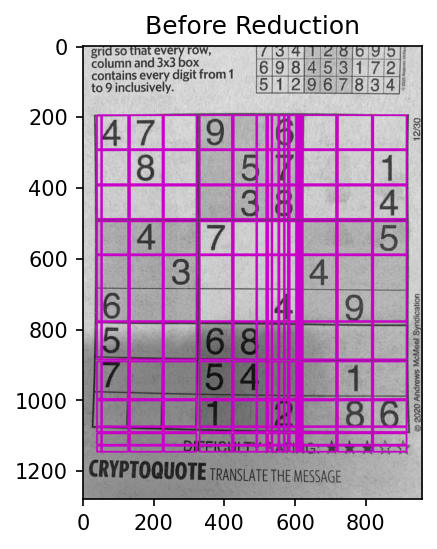

Y coords
min width: 59.04
max width: 128.92
Before: [[195, 291], [294, 390], [394, 488], [495, 588], [779, 885], [891, 1001], [997, 1074]]
After: [[195, 291], [294, 390], [394, 488], [495, 588], [591, 682], [685, 776], [779, 885], [891, 1001], [997, 1074]]
X coords
min width: 77.85000000000001
max width: 105.60000000000001
Before: [[132, 224], [228, 320], [329, 420], [620, 714], [719, 815], [819, 913]]
After: [[132, 224], [228, 320], [329, 420], [425, 517], [523, 615], [620, 714], [719, 815], [819, 913]]


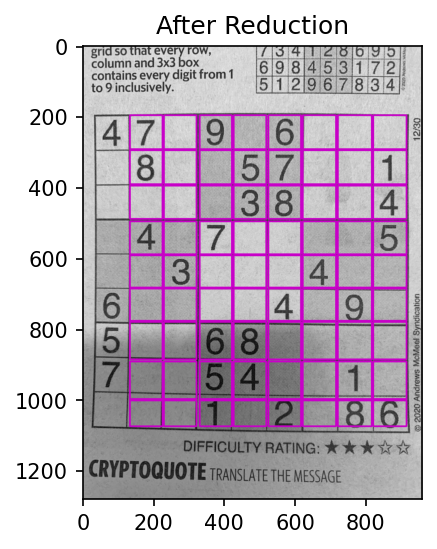

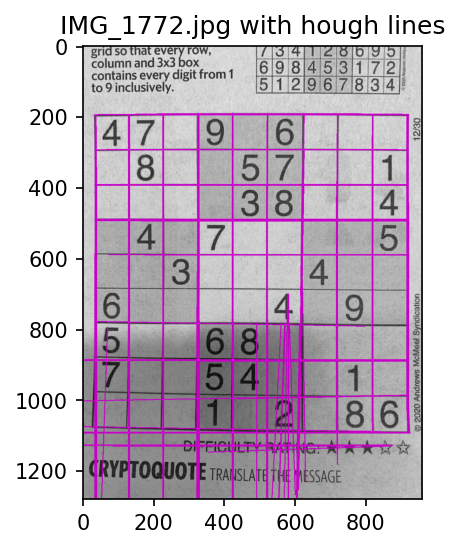

y_coords: [[195, 291], [294, 390], [394, 488], [495, 588], [591, 682], [685, 776], [779, 885], [891, 1001], [997, 1074]]
x_coords: [[132, 224], [228, 320], [329, 420], [425, 517], [523, 615], [620, 714], [719, 815], [819, 913]]


Image: IMG_1631-high.jpg
Shape: [3024, 3024]

Threshold: 1512
Horizontal lines: 162
Vertical lines: 131
Rejected lines: 50


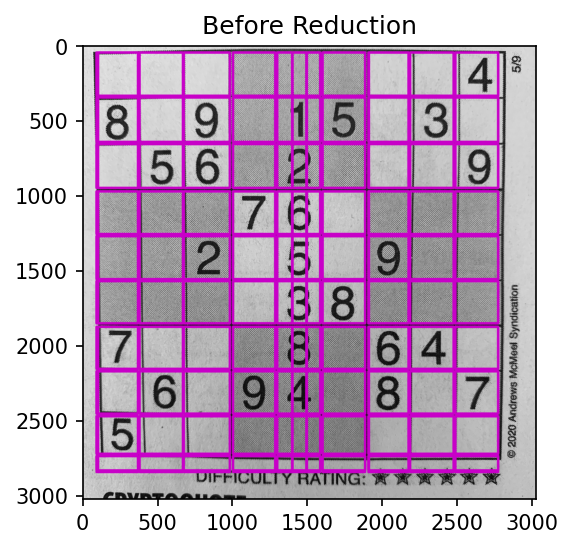

Y coords
min width: 214.02
max width: 326.70000000000005
Before: [[43, 332], [343, 640], [654, 947], [970, 1255], [1269, 1556], [1569, 1851], [1874, 2155], [2171, 2454], [2471, 2722]]
After: [[43, 332], [343, 640], [654, 947], [970, 1255], [1269, 1556], [1569, 1851], [1874, 2155], [2171, 2454], [2471, 2722]]
X coords
min width: 221.94
max width: 338.8
Before: [[100, 367], [377, 667], [672, 980], [1001, 1283], [1599, 1883], [1908, 2173], [2183, 2474], [2485, 2771]]
After: [[100, 367], [377, 667], [672, 980], [1001, 1283], [1294, 1588], [1599, 1883], [1908, 2173], [2183, 2474], [2485, 2771]]


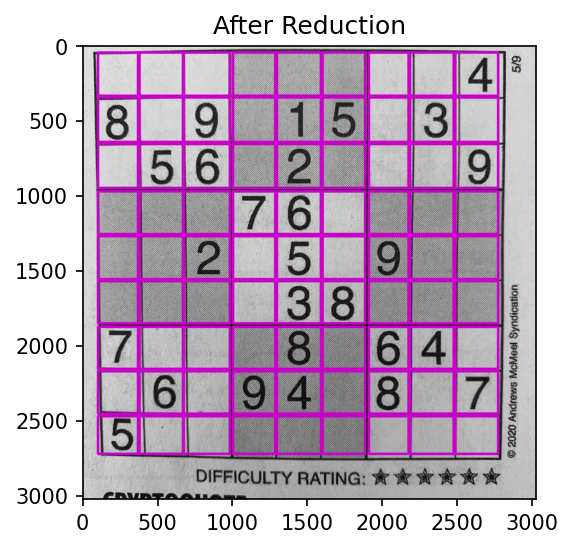

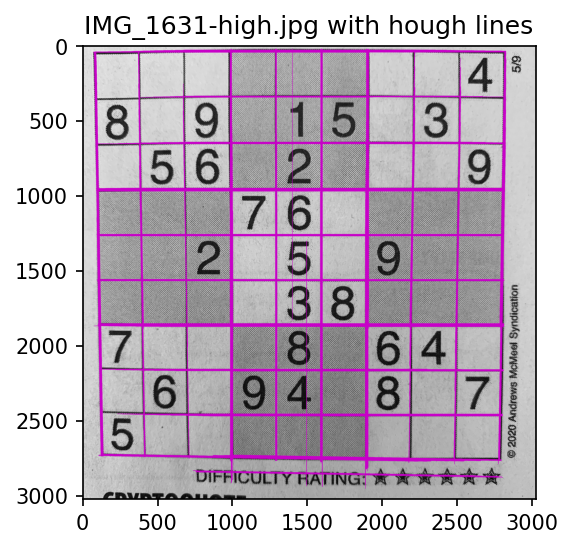

y_coords: [[43, 332], [343, 640], [654, 947], [970, 1255], [1269, 1556], [1569, 1851], [1874, 2155], [2171, 2454], [2471, 2722]]
x_coords: [[100, 367], [377, 667], [672, 980], [1001, 1283], [1294, 1588], [1599, 1883], [1908, 2173], [2183, 2474], [2485, 2771]]


In [8]:
abs_path = os.path.join(os.getcwd(), dir_path)
if not os.path.exists(abs_path):
    raise Exception('Directory \'%s\' does not exist.' % abs_path)
if os.path.isfile(abs_path):
        raise Exception('\'%s\' is a file. It must be a directory.' % abs_path)
for file_name in os.listdir(abs_path):
    full_file_path = os.path.join(abs_path, file_name)
    if os.path.isfile(full_file_path) and file_name[0] != '.':
        image = cv2.imread(full_file_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print('File \'%s\' is not an image.' % file_name)
            break
        print('\n\nImage: %s' % file_name)
        print('Shape: [%s, %s]' % (image.shape[0], image.shape[1]))
        x_coords, y_coords, lines = get_cell_boundaries(image)  
        image_with_lines = image_utils.generate_image_with_lines(image, lines[0]+lines[1], purple)
        image_utils.show_image(image_with_lines, title='%s with hough lines' % file_name)
        print("y_coords: %s" % y_coords)
        print("x_coords: %s" % x_coords)

In [9]:
# Doing this so subsequent runs will work. Otherwise PWD when the notebook starts is directory above /Notebooks.
# It should be /Notebooks
%cd Notebooks

/Users/jk/DevelopmentEnvironment/Voice_Gateway_SOE/Notebooks
